In [48]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.losses import *

In [2]:
ds = torch.load('peaks.pt')
split = RandomSplitter()

In [3]:
train_len = int(0.8 * len(ds))
valid_len = len(ds) - train_len

In [4]:
train_ds, valid_ds = torch.utils.data.dataset.random_split(ds, lengths=[train_len, valid_len])

In [5]:
train_ds[0]

(tensor([[0., 0., 0.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(10., dtype=torch.float64))

In [6]:
train_dl = DataLoader(train_ds, bs=2048, device=torch.device('cuda:0'))
valid_dl = DataLoader(valid_ds, bs=2048)

In [7]:
torch.cuda.is_available()

True

In [49]:
dls = DataLoaders(train_dl, valid_dl).cuda()
x,y = train_dl.one_batch()
x.shape

torch.Size([2048, 5, 601])

In [50]:
def negative_binomial_layer(x):
    n,p = torch.unbind(x, dim=1)
    n,p = [torch.unsqueeze(t,dim=-1) for t in (n,p)]
    n = torch.nn.functional.softplus(n)
    p = torch.sigmoid(p)
    x = torch.cat((n,p), axis=1)
    return x

class CNN(nn.Module):
    def __init__(self, input_size):
        """
        init convolution and activation layers
        Args:
        x: (Nx1x2004)
        class: 

        """
        super(CNN, self).__init__() 
        
        self.conv1 = torch.nn.Conv1d(input_size, 512, 2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(512, 64, 2)
        self.pool = torch.nn.AvgPool1d(4)
        self.fc1 = torch.nn.Linear(2368, 2368)
        self.fc2 = torch.nn.Linear(2368, 2) # 2 becasue 2 params in distribution

    def forward(self, x):
        """
        forward function describes how input tensor is transformed to output tensor
        Args:
            
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        # convert to params of distribution (n and p)
        x = negative_binomial_layer(x)
        return x

def negative_binomial_loss(pred, target):
    n,p = torch.unbind(pred, dim=1)
    n,p = [torch.unsqueeze(t,dim=-1) for t in (n,p)]
    nll = (
        torch.lgamma(n) 
        + torch.lgamma(target + 1)
        - torch.lgamma(n + target)
        - n * torch.log(p)
        - target * torch.log(1 - p)
    )    
    return torch.mean(nll).float()

In [51]:
model = CNN(x.shape[1]).cuda()

In [52]:
y_pred = model.forward(x)
loss = negative_binomial_loss(y_pred, y.unsqueeze(dim=-1))
#loss = torch.nn.functional.mse_loss(y_pred, y.unsqueeze(dim=-1))
loss

tensor(77.4919, device='cuda:0', grad_fn=<CopyBackwards>)

In [55]:
learner = Learner(dls, model, loss_func=negative_binomial_loss)

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.00010964782268274575)

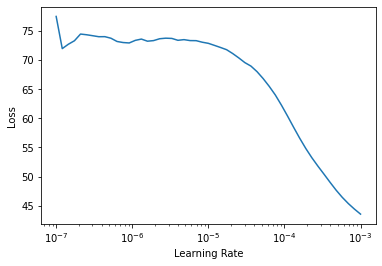

In [54]:
learner.lr_find()

In [56]:
learner.fit_one_cycle(25, lr_max=1e-4)

epoch,train_loss,valid_loss,time
0,15.275882,5.658259,00:24
1,5.928124,5.539675,00:24
2,5.552904,5.539643,00:25
3,5.537381,5.539032,00:24
4,5.537595,5.538644,00:25
5,5.539163,5.539038,00:25
6,5.541195,5.547972,00:25
7,5.541561,5.545842,00:25
8,5.541082,5.541814,00:25
9,5.540207,5.539049,00:25


In [43]:
from scipy.stats import nbinom

pred_params, y_true = learner.get_preds()
n,p = pred_params[:,0], pred_params[:,1]

In [44]:
max_count = ds.tensors[1].max()
nbinom.pmf(max_count, n, p)
y_pred = nbinom.median(n,p)
lower, upper = nbinom.interval(0.8, n, p)
lower, upper, y_pred

(array([3., 3., 3., ..., 3., 3., 3.]),
 array([257., 259., 258., ..., 257., 257., 257.]),
 array([54., 55., 55., ..., 54., 55., 54.]))

<AxesSubplot:>

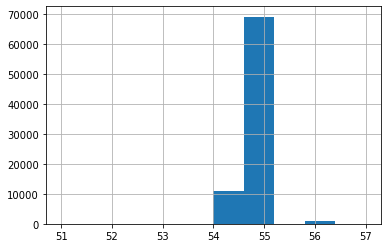

In [45]:
pd.Series(y_pred).hist()